# Background Information and Write-up

## High Level Overview

This project can be split up into two main components: the digitial communications portion and the deep learning portion. On one hand, the digital communications side of the project involves generating symbols based off a given modulation scheme, adding noise to that symbol, and calculating the Log-Likelihood Ratio (LLR) of ecah bit. On the other hand, a neural network is created in order to attempt to predict these LLRs only given the noisy constellation. Note that all the digital communications functions are implemented using MATLAB and fed into Python using .csv files.


## Generating the Data and Digital Communications Background

### Calculating LLRs

The Log-Likelihood Ratio of a bit $i$ is defined by the equation below where $b_i$ is the original bit sent and $r$ is the input to the reciever:

$$ LLR_{b_i} = \log{\left( \frac{p(b_i = 0 | r)}{p(b_i = 1 | r)} \right)}$$

Applying Baye's Rule to this expression, we arrive at:

$$
\begin{align} LLR_{b_i} &= \log{\left( \frac{\frac{p(r | b_i = 0)p(b_i = 0)}{p(r)}}{\frac{p(r | b_i = 1)p(b_i = 1)}{p(r)}} \right)} \\
&= \log{\left( \frac{p(r | b_i = 0)p(b_i = 0)}{p(r |b_i = 1)p(b_i=1)} \right)} \\
&= \log{\left( \frac{p(r | b_i = 0)}{p(r | x = 1)}\right)} + \log{\left(\frac{p(b_i=0)}{p(b_i=1)} \right)} \end{align}
$$

<br> <br>
If we assume our input bits are equally distributed (ie: $p(b_i=0) = p(b_i=1) = 0.5$), the second term vanishes. 

$$LLR_{b_i} = \log{\left( \frac{p(r | b_i = 0)}{p(r | x = 1)}\right)}$$

<br> <br>
Additionally, we assume our noise to be iid multi-dimensional Gaussian random variables with parameters $\mu = \textbf{0}$ and $\Sigma = (N_0/2) I_k$. Lastly, note that there may be several constellations that correspond to $b_i = 0$. Therefore, in order to obtain $p(r | b_i = 0)$, we apply the law of total prbability and sum over the subset of constellations which satisfy $b_i =0$, denoted below as $\mathcal{X_0}$ 


$$ p(r | b_i = 0) = \sum_{x \in \mathcal{X_0}}{\frac{1}{\sqrt{N_0 \pi }}\text{exp} \left( -\frac{1}{N_0} \left\| r - x \right\|^2 \right)}$$

<br><br>
Bringing this all together, we obtain the final expression for the LLR of bit $i$:

$$ LLR_{b_i} = \log{\left( \frac{\sum_{x \in \mathcal{X_0}}{\text{exp} \left( -\frac{1}{N_0} \left\| r - x \right\|^2 \right)}}{\sum_{x \in \mathcal{X_1}}{\text{exp} \left( -\frac{1}{N_0} \left\| r - x \right\|^2 \right)}}\right)}
$$

<br><br>
For BSPK modulation with one dimensional noise, this simplifies to the following:

$$\begin{align} LLR_{b_i} &= \log{\left( \frac{{\text{exp} \left( -\frac{1}{N_0} \left( r - \sqrt{E_b} \right)^2 \right)}}{\text{exp} \left( -\frac{1}{N_0} \left( r + \sqrt{E_b} \right)^2 \right)}\right)} \\
&= 4 \left(\frac{E_b}{N_0} \right) r
\end{align} $$

# Link Google Drive data and load required libraries

##Mount Google Drive to access files


In [1]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')
os.chdir('/content/gdrive/My Drive/LLR_NN')
!ls
!pip install tensorflow-gpu==2.1.0

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/
16_QAM_X_test_var_0.1.csv   8_PSK_y_train_var_0.1.csv  BPSK_X_valid_var_0.1.csv
16_QAM_X_train_var_0.1.csv  8_PSK_y_valid_var_0.1.csv  BPSK_y_test_var_0.1.csv
16_QAM_X_valid_var_0.1.csv  8_QAM_X_test_var_0.1.csv   BPSK_y_train_var_0.1.csv
16_QAM_y_test_var_0.1.csv   8_QAM_X_train_var_0.1.csv  BPSK_y_valid_var_0.1.csv
16_QAM_y_train_var_0.1.csv  8_QAM_X_valid_var_0.1.csv  QPSK_X_test_var_0.1.csv
16_QAM_y_valid_var_0.1.csv  8_QAM_y_test_var_0.1.csv   QPSK_X_tr

##Import Required Libaries

In [0]:
import numpy as np
import scipy.io as sio
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, MaxPooling1D
from tensorflow.keras.layers import Activation,Conv2D, Flatten, Permute, Cropping2D
from tensorflow.keras.layers import ZeroPadding2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Reshape
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
import matplotlib.pyplot as plt

##Load Data

In [11]:
MODULATION = "16_QAM"
NOISE_VAR = "0.1"

# Load the training data
X_train = np.genfromtxt(MODULATION + "_X_train_var_" + NOISE_VAR + ".csv", delimiter=',')
y_train= np.genfromtxt(MODULATION + "_y_train_var_" + NOISE_VAR + ".csv", delimiter=',')

# Load validation error
X_valid = np.genfromtxt(MODULATION + "_X_valid_var_" + NOISE_VAR + ".csv", delimiter=',')
y_valid= np.genfromtxt(MODULATION + "_y_valid_var_" + NOISE_VAR + ".csv", delimiter=',')

# Load the test data
X_test = np.genfromtxt(MODULATION + "_X_test_var_" + NOISE_VAR + ".csv", delimiter=',')
y_test = np.genfromtxt(MODULATION + "_y_test_var_" + NOISE_VAR + ".csv", delimiter=',')

# Reshape the data
X_train = X_train.T
X_valid = X_valid.T
X_test = X_test.T
y_train = y_train.T
y_valid = y_valid.T
y_test = y_test.T

# Special case for M=2 since the data imported was only 1D
if(len(y_train.shape) == 1):
  y_train = y_train.reshape([-1,1])
  y_valid = y_valid.reshape([-1,1])
  y_test = y_test.reshape([-1,1])

print("Training data shape: \t\t", X_train.shape)
print("Validation data shape: \t\t",X_valid.shape)
print("Test data shape: \t\t" ,X_test.shape)

print("Training label shape: \t\t", y_train.shape)
print("Training label shape: \t\t", y_valid.shape)
print("Training label shape: \t\t", y_test.shape)

Training data shape: 		 (10000, 2)
Validation data shape: 		 (1500, 2)
Test data shape: 		 (3000, 2)
Training label shape: 		 (10000, 4)
Training label shape: 		 (1500, 4)
Training label shape: 		 (3000, 4)


# Construct Fully Connected Neural Net


##Define the model. Note that we have multiple outputs corresponding to each bit LLR.

In [4]:
model_input = Input(shape=(X_train.shape[1]), name='model_input')
num_outputs = y_train.shape[1]
num_layers = 7

x = Dense(256, activation='relu')(model_input)
for i in range(num_layers, 1, -1):
  x = Dense(max(num_outputs*2, 2**i), activation="relu")(x)

output_vec = [None]*num_outputs
for i in range(num_outputs):
  out_layer_name = "LLR_bit_" + str(i+1)

  bit_layer = Dense(4, activation  = 'relu', name = "bit_layer_" + str(i + 1))(x)
  output_vec[i] = Dense(1, activation = "linear", name = out_layer_name)(bit_layer)

model = Model(inputs = model_input, outputs = output_vec)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input (InputLayer)        [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          768         model_input[0][0]                
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

##Train the model

In [0]:
# Experimented with model parameters:
# Can choose loss function, metrics, optimizer parameters
model.compile(loss='logcosh',
              optimizer = optimizers.Nadam(),
              metrics = ['mean_squared_error'])

# Since we have one output per bit, store the results of each its own list
y_train_flattened = [None] * num_outputs
y_valid_flattened = [None] * num_outputs
y_test_flattened = [None] * num_outputs

for i in range(num_outputs):
  y_train_flattened[i] = y_train[:,i]
  y_valid_flattened[i] = y_valid[:,i]
  y_test_flattened[i] = y_test[:,i]

history = model.fit(X_train, y_train_flattened, validation_data=(X_valid, y_valid_flattened), batch_size=50, epochs=100, verbose = 0)

##Evaluate the Model

In [23]:
# Test model on the validation and test set and report results
score_val = model.evaluate(X_valid, y_valid_flattened, batch_size = 100, verbose=0)
score_test = model.evaluate(X_test, y_test_flattened, batch_size = 100, verbose=0)

print("Evaluate model on the validation set:")
print("---------------------------------------------------")
print("Total Loss: \t\t\t", score_val[0])
for i in range(num_outputs):
  print("Bit " + str(i) + " [Loss, MSE] is: \t\t", score_val[i+1], "\t, ", score_val[i+3])

print("\n\nEvaluate model on the test set:")
print("---------------------------------------------------")
print("Total Loss: \t\t\t", score_test[0])
for i in range(num_outputs):
  print("Bit " + str(i) + " [Loss, MSE] is: \t\t", score_test[i+1], "\t, ", score_test[i+3])

Evaluate model on the validation set:
---------------------------------------------------
Total Loss: 			 0.36821927229563395
Bit 0 [Loss, MSE] is: 		 0.109039865 	,  0.041812085
Bit 1 [Loss, MSE] is: 		 0.08756699 	,  0.12980035
Bit 2 [Loss, MSE] is: 		 0.041812085 	,  0.2681721
Bit 3 [Loss, MSE] is: 		 0.12980035 	,  0.20138556


Evaluate model on the test set:
---------------------------------------------------
Total Loss: 			 0.34117901722590127
Bit 0 [Loss, MSE] is: 		 0.10360838 	,  0.032007392
Bit 1 [Loss, MSE] is: 		 0.08112338 	,  0.124439865
Bit 2 [Loss, MSE] is: 		 0.032007392 	,  0.2411538
Bit 3 [Loss, MSE] is: 		 0.124439865 	,  0.18651947


##Plot the LLRs acquired from the neural net vs actual LLRs

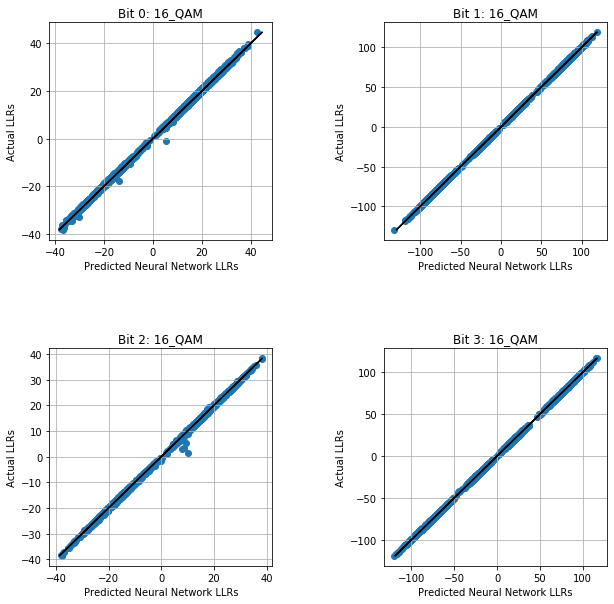

In [48]:
y_pred = [None]*num_outputs
y_pred = model.predict(X_test)

f = plt.figure()
f.set_figheight(10)
f.set_figwidth(10)
for i in range(num_outputs):
  if num_outputs != 1:
    predicted = y_pred[i][:]
  else:
    predicted = y_pred

  plt.subplot(2,2,i+1)
  plt.scatter(np.asarray(predicted), y_test[:,i].reshape([-1,1]))
  plt.plot(y_test[:,i].reshape([-1,1]), y_test[:,i].reshape([-1,1]), 'k')
  plt.xlabel("Predicted Neural Network LLRs")
  plt.ylabel("Actual LLRs")
  plt.title("Bit " + str(i) + ": " + MODULATION)
  plt.grid()

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()